# Energy Star Score

**Objetivo:** prever o Energy Star Score (medida da eficiência energética de um edifício) de diversos edifícios na cidade de New York.

**Técnicas abordadas:** Manipulação de tipos de variáveis, Tratamento de outliers e valores missing, Feature engineering, Cross-validation.

**Algoritmos de classificação utilizados:** SVM, RandomForest e XGBoost

**Método de avaliação da precisão:** mean_absolute_error

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

/Users/brunomaciel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('energy_buildings.csv')
df.set_index('Order', inplace=True)
df.head()

,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10

In [4]:
df.shape

(11746, 59)

In [5]:
df.columns

Index(['Property Id', 'Property Name', 'Parent Property Id',
       'Parent Property Name', 'BBL - 10 digits',
       'NYC Borough, Block and Lot (BBL) self-reported',
       'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
       'Address 2', 'Postal Code', 'Street Number', 'Street Name', 'Borough',
       'DOF Gross Floor Area', 'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy',
       'Metered Areas (Energy)', 'Metered Areas  (Water)', 'ENERGY STAR Score',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normal

<br/> 
## 1. Limpeza dos Dados

#### a) Exclusão de Colunas sem utilidade

In [6]:
# Exclui colunas sem utilidade
cols_a_excluir = ['Property Id', 'Property Name', 'Parent Property Id', 'Parent Property Name', 'BBL - 10 digits', 
                  'NYC Borough, Block and Lot (BBL) self-reported', 'NYC Building Identification Number (BIN)', 
                  'Address 1 (self-reported)', 'Address 2', 'Postal Code', 'Street Number', 'Street Name', 
                  'List of All Property Use Types at Property', 'Release Date', 'NTA']
df2 = df.drop(columns=cols_a_excluir)

#### b) Alteração do nome das colunas

In [7]:
[col.lower().replace(' ', '_') for col in df2.columns]

['borough',
 'dof_gross_floor_area',
 'primary_property_type_-_self_selected',
 'largest_property_use_type',
 'largest_property_use_type_-_gross_floor_area_(ft²)',
 '2nd_largest_property_use_type',
 '2nd_largest_property_use_-_gross_floor_area_(ft²)',
 '3rd_largest_property_use_type',
 '3rd_largest_property_use_type_-_gross_floor_area_(ft²)',
 'year_built',
 'number_of_buildings_-_self-reported',
 'occupancy',
 'metered_areas_(energy)',
 'metered_areas__(water)',
 'energy_star_score',
 'site_eui_(kbtu/ft²)',
 'weather_normalized_site_eui_(kbtu/ft²)',
 'weather_normalized_site_electricity_intensity_(kwh/ft²)',
 'weather_normalized_site_natural_gas_intensity_(therms/ft²)',
 'weather_normalized_source_eui_(kbtu/ft²)',
 'fuel_oil_#1_use_(kbtu)',
 'fuel_oil_#2_use_(kbtu)',
 'fuel_oil_#4_use_(kbtu)',
 'fuel_oil_#5_&_6_use_(kbtu)',
 'diesel_#2_use_(kbtu)',
 'district_steam_use_(kbtu)',
 'natural_gas_use_(kbtu)',
 'weather_normalized_site_natural_gas_use_(therms)',
 'electricity_use_-_grid_pur

In [8]:
# Renomeia colunas por questão de praticidade
df2.columns = ['borough', 'DOF_floor_area', 'property_type', 'property_use_type',
       'property_use_type_floor_area','2nd_property_use_type', '2nd_property_use_type_floor_area',
       '3rd_property_use_type', '3rd_property_use_type_floor_area', 'year_built', 'num_buildings', 'occupancy',
       'metered_areas_energy', 'metered_areas_water', 'ENERGY_STAR_Score',
       'site_EUI', 'weather_normalized_site_EUI', 'weather_normalized_site_electricity_intensity',
       'weather_normalized_site_naturalgas_intensity', 'weather_normalized_source_EUI', 'fuel_oil_1_use',
       'fuel_oil_2_use', 'fuel_oil_4_use', 'fuel_oil_5e6_use', 'diesel_2_use',
       'district_steam_use', 'naturalgas_use', 'weather_normalized_site_naturalgas_use',
       'electricity_use_gridPurchase', 'weather_normalized_site_electricity', 'total_GHG_emissions',
       'direct_GHG_emissions', 'indirect_GHG_emissions', 'property_GFA', 'water_use', 'water_intensity',
       'source_EUI', 'water_required', 'DOF_benchmarking_submission_status', 'latitude', 'longitude',
       'community_board', 'council_district', 'census_tract']

In [9]:
df2.head(4)

,borough,DOF_floor_area,property_type,property_use_type,property_use_type_floor_area,2nd_property_use_type,2nd_property_use_type_floor_area,3rd_property_use_type,3rd_property_use_type_floor_area,year_built,num_buildings,occupancy,metered_areas_energy,metered_areas_water,ENERGY_STAR_Score,site_EUI,weather_normalized_site_EUI,weather_normalized_site_electricity_intensity,weather_normalized_site_naturalgas_intensity,weather_normalized_source_EUI,fuel_oil_1_use,fuel_oil_2_use,fuel_oil_4_use,fuel_oil_5e6_use,diesel_2_use,district_steam_use,naturalgas_use,weather_normalized_site_naturalgas_use,electricity_use_gridPurchase,weather_normalized_site_electricity,total_GHG_emissions,direct_GHG_emissions,indirect_GHG_emissions,property_GFA,water_use,water_intensity,source_EUI,water_required,DOF_benchmarking_submission_status,latitude,longitude,community_board,council_district,census_tract
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Manhattan,289356.0,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0
2,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0
3,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0
4,Manhattan,891040.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),1305748,Not Available,Not Available,Not Available,Not Available,1971,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,1305748,Not Available,Not Available,Not Available,No,In Compliance,40.840746,-73.942854,12.0,10.0,255.0


In [10]:
df2.shape

(11746, 44)

#### c) Substituição de *Not Available* por *NULL*

In [11]:
df3 = df2.replace('Not Available', value=np.nan)
df3.head(4)

,borough,DOF_floor_area,property_type,property_use_type,property_use_type_floor_area,2nd_property_use_type,2nd_property_use_type_floor_area,3rd_property_use_type,3rd_property_use_type_floor_area,year_built,num_buildings,occupancy,metered_areas_energy,metered_areas_water,ENERGY_STAR_Score,site_EUI,weather_normalized_site_EUI,weather_normalized_site_electricity_intensity,weather_normalized_site_naturalgas_intensity,weather_normalized_source_EUI,fuel_oil_1_use,fuel_oil_2_use,fuel_oil_4_use,fuel_oil_5e6_use,diesel_2_use,district_steam_use,naturalgas_use,weather_normalized_site_naturalgas_use,electricity_use_gridPurchase,weather_normalized_site_electricity,total_GHG_emissions,direct_GHG_emissions,indirect_GHG_emissions,property_GFA,water_use,water_intensity,source_EUI,water_required,DOF_benchmarking_submission_status,latitude,longitude,community_board,council_district,census_tract
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Manhattan,289356.0,Office,Office,293447,NaN,NaN,NaN,NaN,1963,2,100,Whole Building,NaN,NaN,305.6,303.1,37.8,NaN,614.2,NaN,NaN,NaN,NaN,NaN,5.15506751E7,NaN,NaN,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,NaN,NaN,619.4,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0
2,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,NaN,NaN,NaN,NaN,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,NaN,1.96248472E7,NaN,NaN,NaN,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,NaN,NaN,404.3,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0
3,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,NaN,NaN,NaN,NaN,1924,1,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,231342,NaN,NaN,NaN,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0
4,Manhattan,891040.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),1305748,NaN,NaN,NaN,NaN,1971,1,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1305748,NaN,NaN,NaN,No,In Compliance,40.840746,-73.942854,12.0,10.0,255.0


#### d) Exclusão de registros sem valor de *Energy Star Score* (atributo target)

In [12]:
print('# Registros com atributo target NULL:', df3.shape[0]-df3['ENERGY_STAR_Score'].dropna().shape[0])

# Registros com atributo target NULL: 2104


In [13]:
# Exclui registros que não possuem 'ENERGY_STAR_Score'
df3.dropna(subset=['ENERGY_STAR_Score'], inplace=True)
df3.shape

(9642, 44)

#### e) Alteração nos tipos dos dados
Muitas variáveis numéricas possuíam valores nulos registrados como 'Not Available'. E por isso foram importadas como tipo *object*. Após substituir esse valores por *NaN*. É possível transformar essas variáveis para tipo *float64*.

In [14]:
df3.dtypes

borough                                           object
DOF_floor_area                                   float64
property_type                                     object
property_use_type                                 object
property_use_type_floor_area                      object
2nd_property_use_type                             object
2nd_property_use_type_floor_area                  object
3rd_property_use_type                             object
3rd_property_use_type_floor_area                  object
year_built                                         int64
num_buildings                                      int64
occupancy                                          int64
metered_areas_energy                              object
metered_areas_water                               object
ENERGY_STAR_Score                                 object
site_EUI                                          object
weather_normalized_site_EUI                       object
weather_normalized_site_electri

In [15]:
for col in df3.columns:
    try:
        df3[col] = df3[col].astype(np.float64)
    except:
        continue

df3.dtypes

borough                                           object
DOF_floor_area                                   float64
property_type                                     object
property_use_type                                 object
property_use_type_floor_area                     float64
2nd_property_use_type                             object
2nd_property_use_type_floor_area                 float64
3rd_property_use_type                             object
3rd_property_use_type_floor_area                 float64
year_built                                       float64
num_buildings                                    float64
occupancy                                        float64
metered_areas_energy                              object
metered_areas_water                               object
ENERGY_STAR_Score                                float64
site_EUI                                         float64
weather_normalized_site_EUI                      float64
weather_normalized_site_electri

#### f) Valores Missing

In [16]:
df3.describe()

,DOF_floor_area,property_use_type_floor_area,2nd_property_use_type_floor_area,3rd_property_use_type_floor_area,year_built,num_buildings,occupancy,ENERGY_STAR_Score,site_EUI,weather_normalized_site_EUI,weather_normalized_site_electricity_intensity,weather_normalized_site_naturalgas_intensity,weather_normalized_source_EUI,fuel_oil_1_use,fuel_oil_2_use,fuel_oil_4_use,fuel_oil_5e6_use,diesel_2_use,district_steam_use,naturalgas_use,weather_normalized_site_naturalgas_use,electricity_use_gridPurchase,weather_normalized_site_electricity,total_GHG_emissions,direct_GHG_emissions,indirect_GHG_emissions,property_GFA,water_use,water_intensity,source_EUI,latitude,longitude,community_board,council_district,census_tract
count,9.579000e+03,9.642000e+03,2379.000000,774.000000,9642.000000,9642.000000,9642.000000,9642.000000,9642.000000,8544.000000,9150.000000,8229.000000,8544.000000,9.000000e+00,2.156000e+03,1.098000e+03,4.310000e+02,11.000000,7.580000e+02,8.640000e+03,8.229000e+03,9.565000e+03,9.150000e+03,9.639000e+03,9.629000e+03,9.633000e+03,9.642000e+03,6.528000e+03,6528.000000,9642.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000
mean,1.645981e+05,1.573911e+05,21985.687306,12456.099096,1948.453537,1.284173,99.033914,59.854594,235.663711,260.673467,9.523617,1.655013,351.486248,3.395398e+06,3.103374e+06,5.381499e+06,2.978050e+06,158630.118182,1.997350e+08,1.266254e+07,1.383092e+05,5.714179e+06,1.688588e+06,2.284571e+03,7.140356e+02,1.572269e+03,1.623669e+05,1.479858e+04,108.211494,326.337949,40.753655,-73.956072,7.303929,16.470467,5167.452619
std,3.028456e+05,2.864760e+05,47730.555547,18133.785356,30.059512,3.953959,5.569673,29.993586,9034.569471,10339.147155,98.071585,103.545717,10960.245148,2.213237e+06,5.336467e+06,6.022002e+06,4.861149e+06,146157.034433,2.776288e+09,5.327085e+08,5.897390e+06,3.263932e+07,9.699950e+06,5.844318e+04,2.680530e+04,5.197059e+04,2.941735e+05,1.180984e+05,687.090187,9609.746685,0.082540,0.045786,4.001438,15.918335,13453.655027
min,5.002800e+04,3.190000e+03,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.085973e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-4.690797e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.313430e+04,1.200000e+02,0.000000e+00,0.000000,0.000000,40.516725,-74.229887,1.000000,1.000000,1.000000
25%,6.500800e+04,6.578025e+04,5300.000000,3039.250000,1927.000000,1.000000,100.000000,37.000000,62.925000,66.300000,3.800000,0.100000,104.100000,1.663594e+06,2.681582e+05,2.278750e+06,0.000000e+00,10460.400000,4.660705e+06,1.237478e+06,1.304060e+04,1.020828e+06,2.954748e+05,3.354000e+02,1.693000e+02,9.400000e+01,6.691725e+04,2.812000e+03,29.370000,100.100000,40.700849,-73.983923,5.000000,4.000000,104.000000
50%,9.128000e+04,9.064150e+04,9796.000000,7781.000000,1941.000000,1.000000,100.000000,65.000000,78.900000,82.900000,5.100000,0.500000,128.800000,4.328815e+06,1.308937e+06,4.395008e+06,3.000450e+05,207000.000000,1.011362e+07,4.206698e+06,4.538070e+04,1.771009e+06,5.163867e+05,5.002000e+02,2.805000e+02,1.649000e+02,9.258400e+04,4.874700e+03,47.190000,124.400000,40.758752,-73.962358,7.000000,10.000000,218.000000
75%,1.546480e+05,1.501948e+05,20000.000000,14327.250000,1965.000000,1.000000,100.000000,85.000000,97.200000,102.200000,8.700000,0.700000,165.000000,4.938947e+06,4.416604e+06,6.546330e+06,4.890396e+06,271708.200000,2.079846e+07,6.840574e+06,7.342220e+04,4.110571e+06,1.203704e+06,8.907500e+02,4.479000e+02,4.004000e+02,1.540000e+05,8.061075e+03,73.175000,160.100000,40.822997,-73.929232,10.000000,33.000000,550.000000
max,1.354011e+07,1.421712e+07,943990.000000,212509.000000,2019.000000,155.000000,100.000000,100.000000,869265.000000,939329.000000,5304.400000,9393.000000,986366.000000,6.275850e+06,1.046849e+08,7.907464e+07,4.410378e+07,414000.000000,7.163518e+10,4.945919e+10,5.344590e+08,1.691763e+09,4.958273e+08,4.764456e+06,2.627015e+06,4.764375e+06,1.421712e+07,3.491538e+06,21689.360

In [17]:
dict_missing = {}
for col in df3.columns:
    n_missing = int(df3.shape[0] - df3[col].dropna().shape[0])
    
    dict_missing[col] = [n_missing, round(n_missing / df3.shape[0] * 100, 2)]

df_missing = pd.DataFrame(dict_missing, index=['# missing', '% missing']).transpose()
df_missing = df_missing.sort_values('# missing', ascending=False)
df_missing[df_missing['% missing'] > 0]

,# missing,% missing
fuel_oil_1_use,9633.0,99.91
diesel_2_use,9631.0,99.89
fuel_oil_5e6_use,9211.0,95.53
district_steam_use,8884.0,92.14
3rd_property_use_type_floor_area,8868.0,91.97
3rd_property_use_type,8868.0,91.97
fuel_oil_4_use,8544.0,88.61
fuel_oil_2_use,7486.0,77.64
2nd_property_use_type_floor_area,7263.0,75.33
2nd_property_use_type,7263.0,75.33


In [18]:
# Exclui colunas com 50%+ valores missing
cols_a_excluir = df_missing[df_missing['% missing'] > 50.].index.to_list()
df4 = df3.drop(columns=cols_a_excluir)

print('Shape anterior do DataFrame:', df3.shape)
print('Quantidade de colunas excluidas:', len(cols_a_excluir))
print('Shape atual do DataFrame:', df4.shape)

Shape anterior do DataFrame: (9642, 44)
Quantidade de colunas excluidas: 10
Shape atual do DataFrame: (9642, 34)


<br/><br/> 
## 2. Análise Exploratória e Mais Tratamento nos Dados

In [19]:
df4.describe()

,DOF_floor_area,property_use_type_floor_area,year_built,num_buildings,occupancy,ENERGY_STAR_Score,site_EUI,weather_normalized_site_EUI,weather_normalized_site_electricity_intensity,weather_normalized_site_naturalgas_intensity,weather_normalized_source_EUI,naturalgas_use,weather_normalized_site_naturalgas_use,electricity_use_gridPurchase,weather_normalized_site_electricity,total_GHG_emissions,direct_GHG_emissions,indirect_GHG_emissions,property_GFA,water_use,water_intensity,source_EUI,latitude,longitude,community_board,council_district,census_tract
count,9.579000e+03,9.642000e+03,9642.000000,9642.000000,9642.000000,9642.000000,9642.000000,8544.000000,9150.000000,8229.000000,8544.000000,8.640000e+03,8.229000e+03,9.565000e+03,9.150000e+03,9.639000e+03,9.629000e+03,9.633000e+03,9.642000e+03,6.528000e+03,6528.000000,9642.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000
mean,1.645981e+05,1.573911e+05,1948.453537,1.284173,99.033914,59.854594,235.663711,260.673467,9.523617,1.655013,351.486248,1.266254e+07,1.383092e+05,5.714179e+06,1.688588e+06,2.284571e+03,7.140356e+02,1.572269e+03,1.623669e+05,1.479858e+04,108.211494,326.337949,40.753655,-73.956072,7.303929,16.470467,5167.452619
std,3.028456e+05,2.864760e+05,30.059512,3.953959,5.569673,29.993586,9034.569471,10339.147155,98.071585,103.545717,10960.245148,5.327085e+08,5.897390e+06,3.263932e+07,9.699950e+06,5.844318e+04,2.680530e+04,5.197059e+04,2.941735e+05,1.180984e+05,687.090187,9609.746685,0.082540,0.045786,4.001438,15.918335,13453.655027
min,5.002800e+04,3.190000e+03,1600.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.313430e+04,1.200000e+02,0.000000e+00,0.000000,0.000000,40.516725,-74.229887,1.000000,1.000000,1.000000
25%,6.500800e+04,6.578025e+04,1927.000000,1.000000,100.000000,37.000000,62.925000,66.300000,3.800000,0.100000,104.100000,1.237478e+06,1.304060e+04,1.020828e+06,2.954748e+05,3.354000e+02,1.693000e+02,9.400000e+01,6.691725e+04,2.812000e+03,29.370000,100.100000,40.700849,-73.983923,5.000000,4.000000,104.000000
50%,9.128000e+04,9.064150e+04,1941.000000,1.000000,100.000000,65.000000,78.900000,82.900000,5.100000,0.500000,128.800000,4.206698e+06,4.538070e+04,1.771009e+06,5.163867e+05,5.002000e+02,2.805000e+02,1.649000e+02,9.258400e+04,4.874700e+03,47.190000,124.400000,40.758752,-73.962358,7.000000,10.000000,218.000000
75%,1.546480e+05,1.501948e+05,1965.000000,1.000000,100.000000,85.000000,97.200000,102.200000,8.700000,0.700000,165.000000,6.840574e+06,7.342220e+04,4.110571e+06,1.203704e+06,8.907500e+02,4.479000e+02,4.004000e+02,1.540000e+05,8.061075e+03,73.175000,160.100000,40.822997,-73.929232,10.000000,33.000000,550.000000
max,1.354011e+07,1.421712e+07,2019.000000,155.000000,100.000000,100.000000,869265.000000,939329.000000,5304.400000,9393.000000,986366.000000,4.945919e+10,5.344590e+08,1.691763e+09,4.958273e+08,4.764456e+06,2.627015e+06,4.764375e+06,1.421712e+07,3.491538e+06,21689.360000,912801.100000,40.912869,-73.740543,56.000000,51.000000,117602.000000


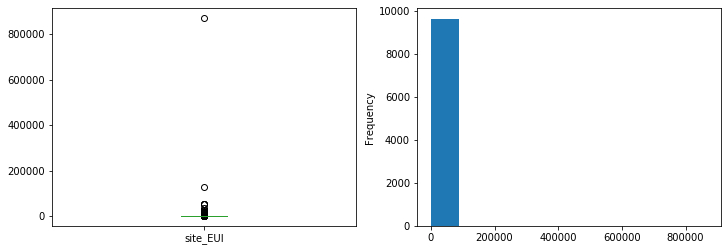

In [20]:
plt.subplot(1, 2, 1)
df4['site_EUI'].plot(kind='box', figsize=(12, 4))
plt.subplot(1, 2, 2)
df4['site_EUI'].plot(kind='hist', figsize=(12, 4))
plt.show()

### 2.1 Removendo Outliers (coluna *site_EUI*)
**Técnica:** Valores menores que ***25% - 3(75%-25%)*** e maiores que ***75% + 3(75%-25%)***

In [21]:
def find_outliers(df, col):
    first_quartile = df[col].describe()['25%']
    third_quartile = df[col].describe()['75%']
    
    iqr = third_quartile - first_quartile
    
    min_valid_value = first_quartile - 3*iqr
    max_valid_value = third_quartile + 3*iqr

    outliers = df.query('{} > {} | {} < {}'.format(col, max_valid_value, col, min_valid_value))
    print('Outliers encontrados:', outliers.shape[0])
    print('Valor de outlier:')
    print('  > {:.4f}\n  < {:.4f}'.format(max_valid_value, min_valid_value))
    
    return outliers.index

Outliers encontrados: 197
Valor de outlier:
  > 200.0250
  < -39.9000


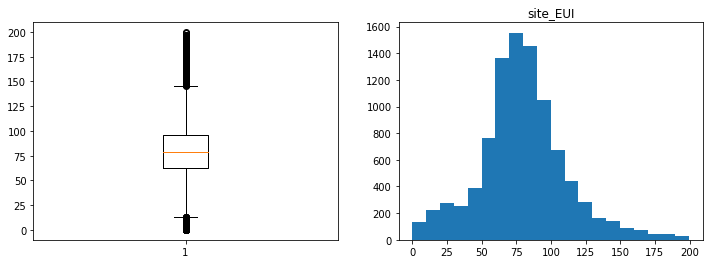

In [22]:
df5 = df4.drop(index=find_outliers(df4, 'site_EUI'), axis=0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.boxplot(df5['site_EUI'])
plt.subplot(1, 2, 2)
plt.hist(df5['site_EUI'], bins=20)
plt.title('site_EUI')
plt.show()

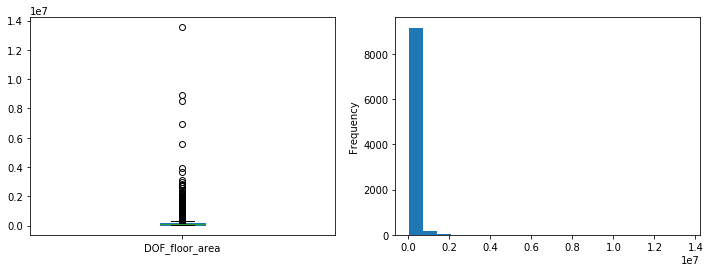

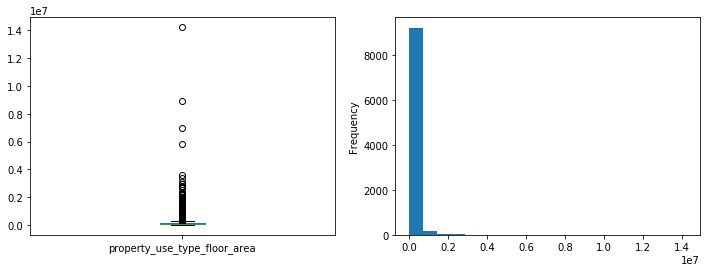

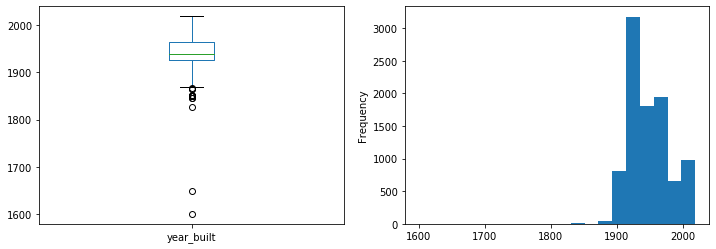

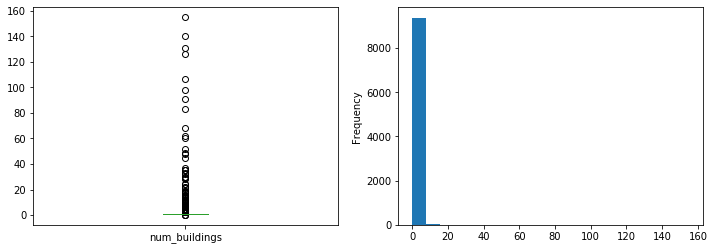

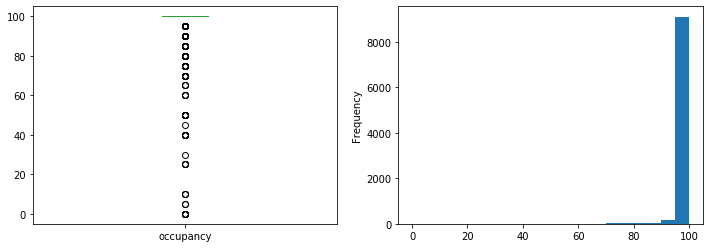

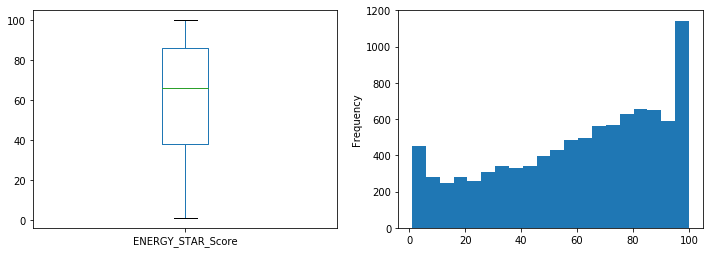

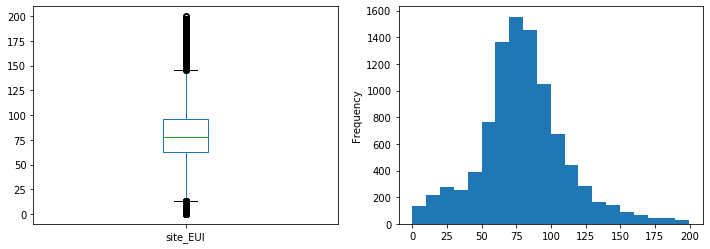

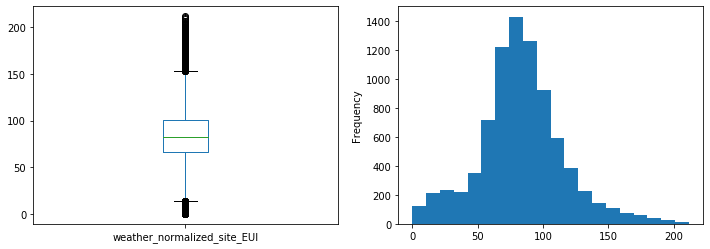

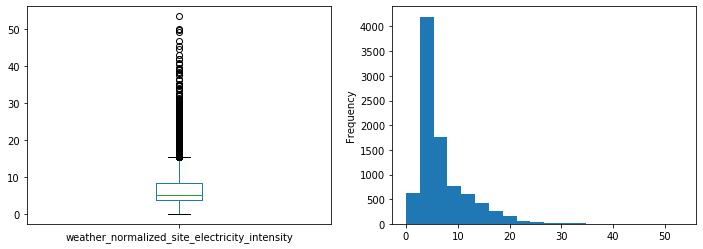

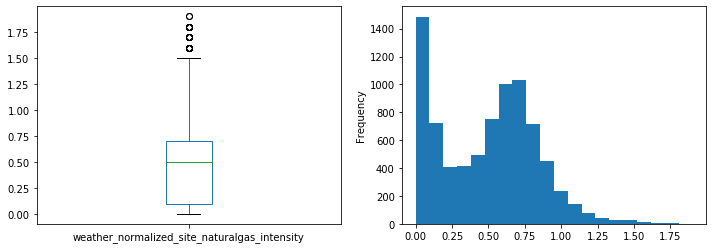

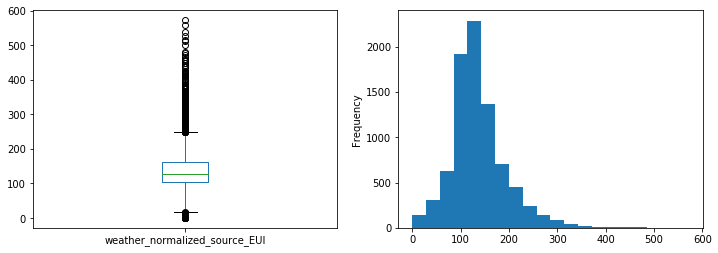

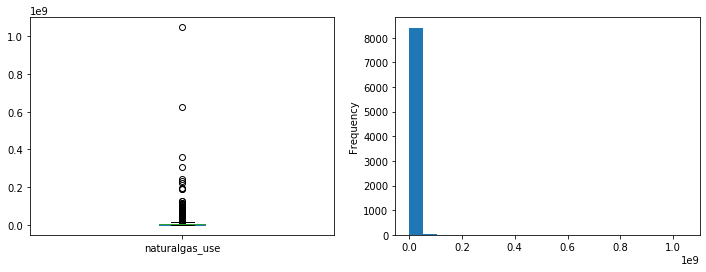

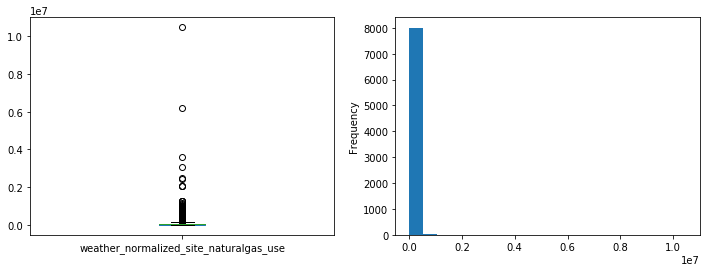

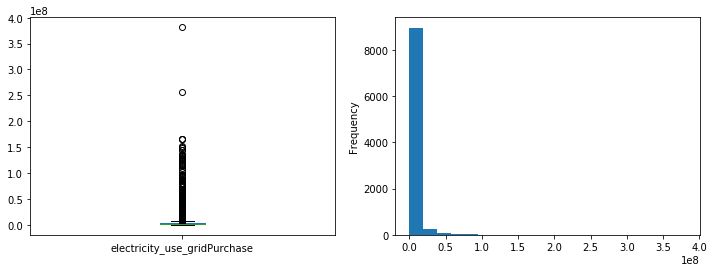

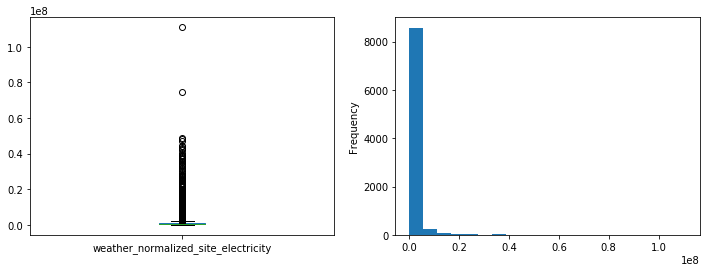

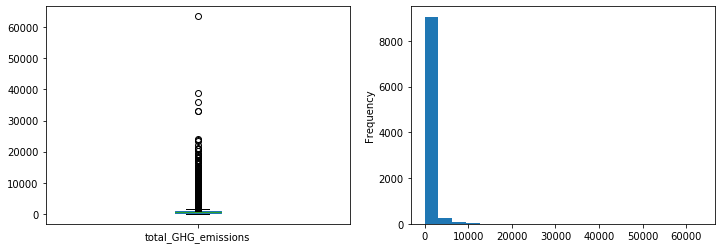

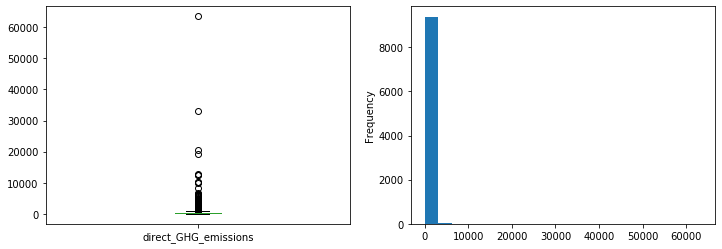

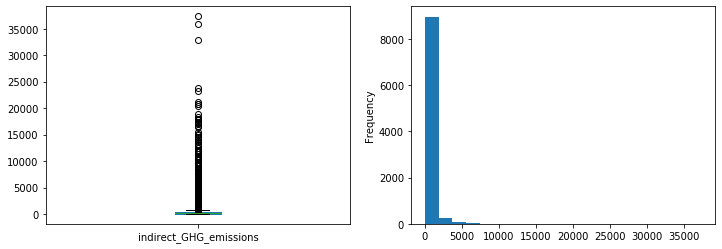

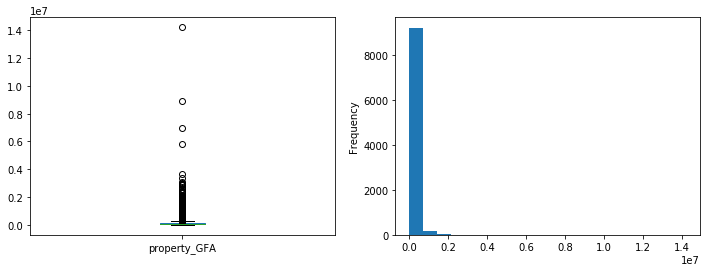

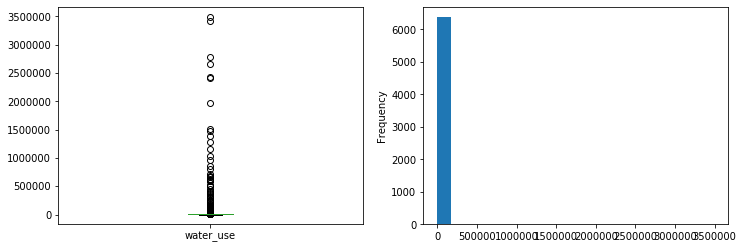

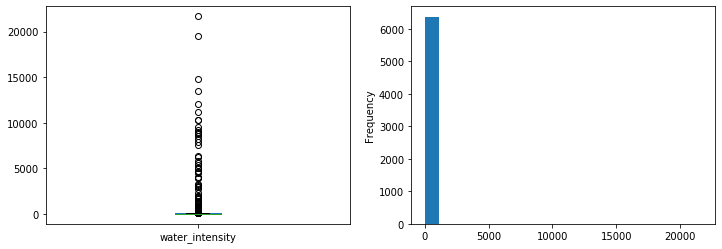

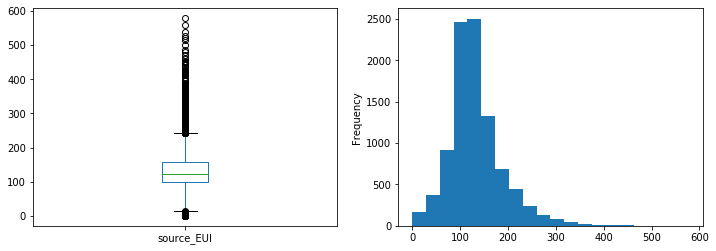

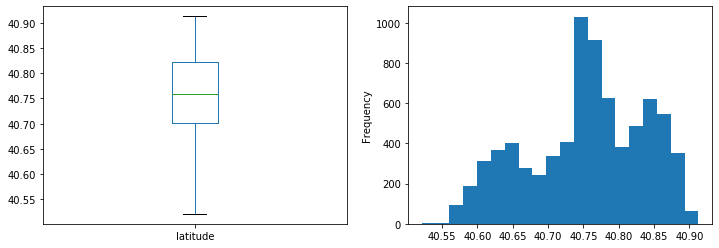

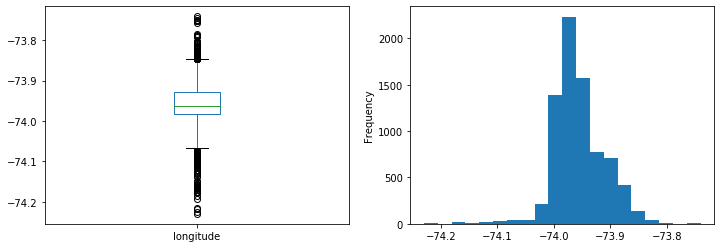

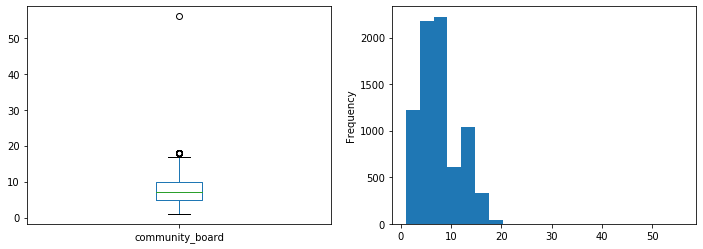

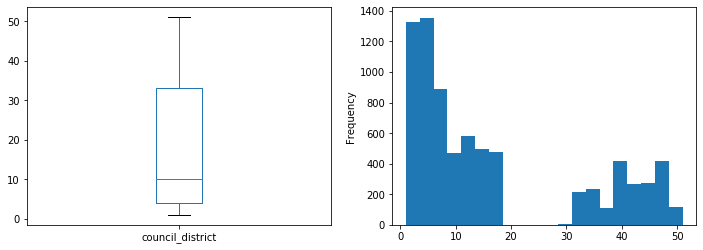

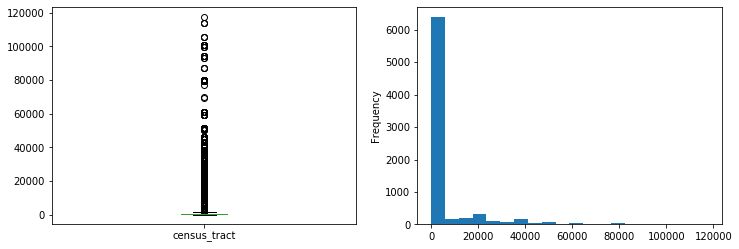

In [23]:
for col in df5.columns:
    try:
        plt.subplot(1, 2, 1)
        df5[col].plot(kind='box', figsize=(12, 4))
        plt.subplot(1, 2, 2)
        df5[col].plot(kind='hist', bins=20, figsize=(12, 4))
        
        plt.show()
    except:
        continue

<br/><br/> 
### 2.2 Remoção de Atributos Colineares

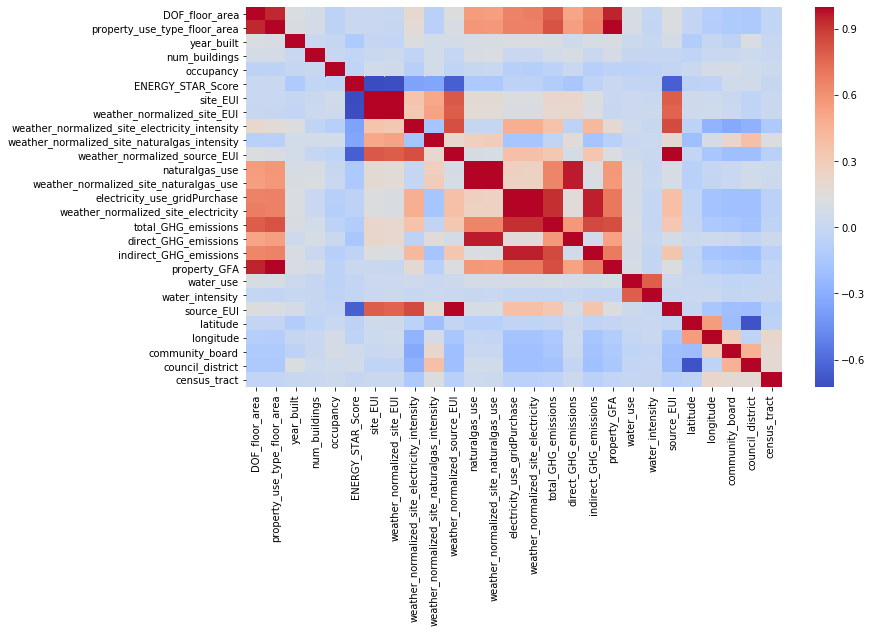

,DOF_floor_area,property_use_type_floor_area,year_built,num_buildings,occupancy,ENERGY_STAR_Score,site_EUI,weather_normalized_site_EUI,weather_normalized_site_electricity_intensity,weather_normalized_site_naturalgas_intensity,weather_normalized_source_EUI,naturalgas_use,weather_normalized_site_naturalgas_use,electricity_use_gridPurchase,weather_normalized_site_electricity,total_GHG_emissions,direct_GHG_emissions,indirect_GHG_emissions,property_GFA,water_use,water_intensity,source_EUI,latitude,longitude,community_board,council_district,census_tract
site_EUI,0.019449,0.015843,-0.006693,0.020395,0.057214,-0.724528,1.000000,0.996493,0.357590,0.506862,0.810165,0.184407,0.184555,0.127567,0.127275,0.219181,0.216878,0.129157,0.019766,0.023913,0.017840,0.797296,0.048553,0.041907,0.019653,-0.033943,0.017868
weather_normalized_site_EUI,0.006454,0.002823,-0.017357,0.024250,0.046804,-0.714589,0.996493,1.000000,0.327711,0.522274,0.791227,0.174648,0.177880,0.108446,0.107708,0.200823,0.209444,0.110819,0.005991,0.027841,0.030778,0.772636,0.046980,0.050968,0.025090,-0.024779,0.022736
naturalgas_use,0.557330,0.578206,0.093159,0.103989,0.008282,-0.132603,0.184407,0.174648,-0.001496,0.279006,0.090290,1.000000,0.999369,0.273286,0.263634,0.654039,0.963232,0.118573,0.569159,0.075749,0.009591,0.094792,-0.072390,-0.007691,0.015520,0.056032,0.043316
weather_normalized_site_naturalgas_use,0.544085,0.574439,0.097858,0.111343,0.010324,-0.134078,0.184555,0.177880,-0.004186,0.289176,0.091399,0.999369,1.000000,0.263490,0.258102,0.651741,0.960626,0.113269,0.565108,0.077388,0.010466,0.092973,-0.077346,-0.014302,0.014444,0.058613,0.035927
electricity_use_gridPurchase,0.659698,0.668196,0.112823,0.014241,-0.080539,-0.049805,0.127567,0.108446,0.472914,-0.160903,0.378128,0.273286,0.263490,1.000000,0.999901,0.923841,0.170623,0.958942,0.699747,0.088713,-0.009878,0.384131,-0.029759,-0.172446,-0.194351,-0.195439,-0.062586
weather_normalized_site_electricity,0.677317,0.665159,0.113037,0.013269,-0.085553,-0.047382,0.127275,0.107708,0.473355,-0.161006,0.377937,0.263634,0.258102,0.999901,1.000000,0.924996,0.159810,0.958548,0.697222,0.090428,-0.009589,0.386142,-0.032882,-0.175243,-0.195269,-0.195078,-0.063709
source_EUI,0.127165,0.114667,0.079038,-0.006928,-0.015918,-0.643712,0.797296,0.772636,0.849605,0.191357,0.998448,0.094792,0.092973,0.384131,0.386142,0.336212,0.089572,0.351967,0.129172,0.032030,0.009264,1.000000,-0.008005,-0.155054,-0.201548,-0.206351,-0.071560
weather_normalized_source_EUI,0.128323,0.107289,0.075667,-0.003795,-0.033165,-0.648656,0.810165,0.791227,0.836928,0.207249,1.000000,0.090290,0.091399,0.378128,0.377937,0.329924,0.086245,0.345262,0.121351,0.034498,0.016863,0.998448,-0.014539,-0.151968,-0.200803,-0.199816,-0.071726
property_use_type_floor_area,0.942278,1.000000,0.107002,0.082190,-0.050491,0.018677,0.015843,0.002823,0.169641,-0.065950,0.107289,0.578206,0.574439,0.668196,0.665159,0.824723,0.545126,0.657955,0.995975,0.094066,-0.011022,0.114667,-0.014680,-0.091751,-0.118423,-0.132407,-0.019314
property_GFA,0.946268,0.995975,0.108623,0.078948,-0.052871,0.017661,0.019766,0.005991,0.188622,-0.074233,0.121351,0.569159,0.565108,0.699747,0.697222,0.842002,0.532682,0.686834,1.000000,0.092414,-0.012006,0.129172,-0.015373,-0.098917,-0.125195,-0.140332,-0.022827


In [24]:
# Colunas com correlações parecidas:
# 'site_EUI' e 'weather_normalized_site_EUI'
# 'naturalgas_use' e 'weather_normalized_site_naturalgas_use'
# 'electricity_use_gridPurchase' e 'weather_normalized_site_electricity'
# 'source_EUI' e 'weather_normalized_source_EUI'

plt.figure(figsize=(12, 7))
sns.heatmap(df5.corr(), cmap='coolwarm')
plt.show()

df5.corr().loc[['site_EUI', 'weather_normalized_site_EUI', 
                'naturalgas_use', 'weather_normalized_site_naturalgas_use', 
                'electricity_use_gridPurchase', 'weather_normalized_site_electricity', 
                'source_EUI', 'weather_normalized_source_EUI',
                'property_use_type_floor_area', 'property_GFA'], :]

In [25]:
df6 = df5.drop(columns=['weather_normalized_site_EUI', 'weather_normalized_site_naturalgas_use', 
                        'weather_normalized_site_electricity', 'weather_normalized_source_EUI',
                        'property_GFA'])
df6.shape

(9445, 29)

In [26]:
df6.head(10)

,borough,DOF_floor_area,property_type,property_use_type,property_use_type_floor_area,year_built,num_buildings,occupancy,metered_areas_energy,metered_areas_water,ENERGY_STAR_Score,site_EUI,weather_normalized_site_electricity_intensity,weather_normalized_site_naturalgas_intensity,naturalgas_use,electricity_use_gridPurchase,total_GHG_emissions,direct_GHG_emissions,indirect_GHG_emissions,water_use,water_intensity,source_EUI,water_required,DOF_benchmarking_submission_status,latitude,longitude,community_board,council_district,census_tract
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,NaN,NaN,Multifamily Housing,Multifamily Housing,412503.0,1903.0,2.0,100.0,Whole Building,Whole Building,93.0,32.0,7.5,0.0,2047200.0,11241926.1,1194.0,150.8,1043.2,22061.0,51.01,87.9,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,Multifamily Housing,Multifamily Housing,321464.0,1939.0,2.0,100.0,Whole Building,Whole Building,72.0,76.2,3.5,0.0,880200.0,3968641.7,1893.4,1525.1,368.3,5915.6,18.40,103.3,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN
22,Manhattan,179130.0,Multifamily Housing,Multifamily Housing,204720.0,1939.0,1.0,100.0,Whole Building,NaN,67.0,75.7,4.0,0.0,553439.4,2886852.2,1204.4,936.5,267.9,NaN,NaN,106.6,NaN,In Compliance,40.857943,-73.934962,12.0,10.0,281.0
23,Manhattan,102150.0,Multifamily Housing,Multifamily Housing,116744.0,1939.0,1.0,100.0,Whole Building,NaN,80.0,77.1,2.6,0.0,326760.6,1081789.4,689.0,588.6,100.4,NaN,NaN,97.7,Yes,In Compliance,40.858256,-73.934734,12.0,10.0,281.0
24,NaN,NaN,Multifamily Housing,Multifamily Housing,189766.0,1911.0,2.0,100.0,Whole Building,Whole Building,100.0,68.0,6.1,0.5,8786386.9,4013954.9,847.5,475.0,372.5,NaN,NaN,115.6,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN
25,Manhattan,151666.0,Multifamily Housing,Multifamily Housing,130629.0,1911.0,1.0,100.0,Another configuration,NaN,100.0,23.7,6.8,NaN,NaN,3090622.7,286.8,0.0,286.8,NaN,NaN,74.3,NaN,In Compliance,40.773465,-73.962116,8.0,4.0,130.0
26,Manhattan,64827.0,Multifamily Housing,Multifamily Housing,54913.0,1911.0,1.0,100.0,Another configuration,NaN,100.0,17.9,4.8,0.0,59412.9,923332.2,88.8,3.2,85.7,231.9,4.22,53.9,Yes,In Compliance,40.773843,-73.961838,8.0,4.0,130.0
33,Manhattan,175885.0,Multifamily Housing,Multifamily Housing,175885.0,1973.0,2.0,100.0,Whole Building,Whole Building,40.0,56.2,10.7,0.2,3826349.7,6056300.2,765.3,203.2,562.0,237.9,1.35,131.0,NaN,In Compliance,40.786238,-73.939958,11.0,8.0,162.0
34,Queens,167856.0,Multifamily Housing,Multifamily Housing,152308.0,1952.0,4.0,100.0,Whole Building,Whole Building,67.0,49.5,7.4,0.3,3634699.8,3900932.9,555.1,193.1,362.0,NaN,NaN,105.5,NaN,In Compliance,NaN,NaN,NaN,NaN,NaN


<br/> 
### 2.3 Relacionamento com o atributo target

In [27]:
df6.corr()['ENERGY_STAR_Score'].sort_values()

site_EUI                                        -0.724528
source_EUI                                      -0.643712
weather_normalized_site_electricity_intensity   -0.358196
weather_normalized_site_naturalgas_intensity    -0.345331
direct_GHG_emissions                            -0.145521
naturalgas_use                                  -0.132603
year_built                                      -0.121938
total_GHG_emissions                             -0.111405
electricity_use_gridPurchase                    -0.049805
latitude                                        -0.048579
indirect_GHG_emissions                          -0.043307
longitude                                       -0.038196
occupancy                                       -0.033222
num_buildings                                   -0.022605
water_use                                       -0.013601
water_intensity                                 -0.012266
census_tract                                    -0.002667
DOF_floor_area

<br/> 
### 2.4 Valores Missing Restantes

#### a) Variáveis Numéricas
Substitui pela mediana

In [28]:
dict_missing = {}
for col in df6.columns:
    n_missing = int(df6.shape[0] - df6[col].dropna().shape[0])
    
    dict_missing[col] = [n_missing, round(n_missing / df6.shape[0] * 100, 2)]

df_missing = pd.DataFrame(dict_missing, index=['# missing', '% missing']).transpose()
df_missing = df_missing.sort_values('# missing', ascending=False)
df_missing[df_missing['% missing'] > 0]

,# missing,% missing
metered_areas_water,3654.0,38.69
water_intensity,3026.0,32.04
water_use,3026.0,32.04
census_tract,1791.0,18.96
council_district,1791.0,18.96
community_board,1791.0,18.96
longitude,1791.0,18.96
latitude,1791.0,18.96
weather_normalized_site_naturalgas_intensity,1379.0,14.60
naturalgas_use,981.0,10.39


In [29]:
df7 = df6.copy()

for col in df7.columns:
    try:
        df7[col].replace(np.nan, value=df7[col].median(), inplace=True)
    except:
        continue

print('Antes:  {} com {} missing'.format(df6.shape, df6.shape[0]-df6.dropna().shape[0]))
print('Depois: {} com {} missing'.format(df7.shape, df7.shape[0]-df7.dropna().shape[0]))

Antes:  (9445, 29) com 6225 missing
Depois: (9445, 29) com 3706 missing


#### b) Variáveis Categóricas
Análise de cada variável em particular para decidir como tratar os valores missing

In [30]:
df_aux = df7.copy()
dict_missing = {}
for col in df_aux.columns:
    n_missing = int(df_aux.shape[0] - df_aux[col].dropna().shape[0])
    
    dict_missing[col] = [n_missing, round(n_missing / df_aux.shape[0] * 100, 2)]

df_missing = pd.DataFrame(dict_missing, index=['# missing', '% missing']).transpose()
df_missing = df_missing.sort_values('# missing', ascending=False)
df_missing[df_missing['% missing'] > 0]

,# missing,% missing
metered_areas_water,3654.0,38.69
water_required,78.0,0.83
borough,47.0,0.50
DOF_benchmarking_submission_status,23.0,0.24
metered_areas_energy,3.0,0.03


In [31]:
for col in df_missing[df_missing['% missing'] > 0].index.values:
    print('\n', df7[col].value_counts())


 Whole Building                            5777
Combination of common and tenant areas       8
Common areas only                            3
Tenant areas only                            2
Another configuration                        1
Name: metered_areas_water, dtype: int64

 Yes    6128
No     3239
Name: water_required, dtype: int64

 Manhattan        3979
Brooklyn         1946
Queens           1700
Bronx            1655
Staten Island     118
Name: borough, dtype: int64

 In Compliance    9422
Name: DOF_benchmarking_submission_status, dtype: int64

 Whole Building           9426
Another configuration      16
Name: metered_areas_energy, dtype: int64


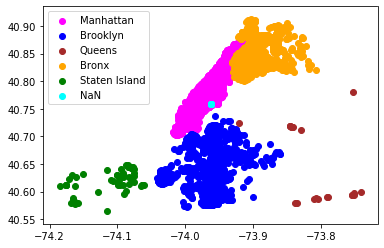

In [32]:
df_aux = df7.dropna()
plt.scatter(df_aux['longitude'][df_aux['borough'] == 'Manhattan'], df_aux['latitude'][df_aux['borough'] == 'Manhattan'], 
            color='magenta', label='Manhattan')

plt.scatter(df_aux['longitude'][df_aux['borough'] == 'Brooklyn'], df_aux['latitude'][df_aux['borough'] == 'Brooklyn'], 
            color='b', label='Brooklyn')

plt.scatter(df_aux['longitude'][df_aux['borough'] == 'Queens'], df_aux['latitude'][df_aux['borough'] == 'Queens'], 
            color='brown', label='Queens')

plt.scatter(df_aux['longitude'][df_aux['borough'] == 'Bronx'], df_aux['latitude'][df_aux['borough'] == 'Bronx'], 
            color='orange', label='Bronx')

plt.scatter(df_aux['longitude'][df_aux['borough'] == 'Staten Island'], df_aux['latitude'][df_aux['borough'] == 'Staten Island'], 
            color='g', label='Staten Island')

plt.scatter(df7['longitude'][df7['borough'].isna()], df7['latitude'][df7['borough'].isna()], 
            color='cyan', label='NaN')

plt.legend()
plt.show()

In [33]:
# Colunas 'metered_areas_water', 'metered_areas_energy' e 'DOF_benchmarking_submission_status'
# possuem maior parte dos registros com 1 unico valor, sendo dispensáveis
df8 = df7.drop(columns=['metered_areas_water', 'metered_areas_energy', 'DOF_benchmarking_submission_status'])

# Substitui dados missing da Coluna 'borough' por 'Manhattan'
df8['borough'].replace(np.nan, 'Manhattan', inplace=True)

# Substitui dados missing da Coluna 'water_required' por 'Yes' (valor mais frequente)
df8['water_required'].replace(np.nan, 'Yes', inplace=True)

print('Dados Missing:', df8.shape[0]-df8.dropna().shape[0])

Dados Missing: 0


<br/><br/><br/>
## Pré-Processamento

In [34]:
def one_hot_encoder(df, features):
    dataframe = df.copy()
    
    for feature in features:
        feature_unique_values = np.sort(dataframe[feature].unique())
        
        # se a coluna só possui 2 valores, substitui os valores por 0 e 1
        if len(feature_unique_values) == 2:
            first_value = feature_unique_values[0]
            second_value = feature_unique_values[1]
            dataframe[feature].replace(first_value, 0, inplace=True)
            dataframe[feature].replace(second_value, 1, inplace=True)
        # para colunas com mais de 2 valores, 
        # cria novas colunas para cada um dos valores, e exclui a coluna original
        else:
            for value in feature_unique_values:
                dataframe[value] = np.zeros(dataframe.shape[0])
                dataframe[value] = (dataframe[feature] == value).astype(int)
            dataframe.drop(columns=feature, inplace=True)
    
    return dataframe

In [35]:
df8.head()

,borough,DOF_floor_area,property_type,property_use_type,property_use_type_floor_area,year_built,num_buildings,occupancy,ENERGY_STAR_Score,site_EUI,weather_normalized_site_electricity_intensity,weather_normalized_site_naturalgas_intensity,naturalgas_use,electricity_use_gridPurchase,total_GHG_emissions,direct_GHG_emissions,indirect_GHG_emissions,water_use,water_intensity,source_EUI,water_required,latitude,longitude,community_board,council_district,census_tract
Order,,,,,,,,,,,,,,,,,,,,,,,,,,
15,Manhattan,90982.5,Multifamily Housing,Multifamily Housing,412503.0,1903.0,2.0,100.0,93.0,32.0,7.5,0.0,2047200.0,11241926.1,1194.0,150.8,1043.2,22061.0,51.01,87.9,Yes,40.758878,-73.962238,7.0,10.0,219.0
21,Manhattan,90982.5,Multifamily Housing,Multifamily Housing,321464.0,1939.0,2.0,100.0,72.0,76.2,3.5,0.0,880200.0,3968641.7,1893.4,1525.1,368.3,5915.6,18.40,103.3,Yes,40.758878,-73.962238,7.0,10.0,219.0
22,Manhattan,179130.0,Multifamily Housing,Multifamily Housing,204720.0,1939.0,1.0,100.0,67.0,75.7,4.0,0.0,553439.4,2886852.2,1204.4,936.5,267.9,4854.1,47.02,106.6,Yes,40.857943,-73.934962,12.0,10.0,281.0
23,Manhattan,102150.0,Multifamily Housing,Multifamily Housing,116744.0,1939.0,1.0,100.0,80.0,77.1,2.6,0.0,326760.6,1081789.4,689.0,588.6,100.4,4854.1,47.02,97.7,Yes,40.858256,-73.934734,12.0,10.0,281.0
24,Manhattan,90982.5,Multifamily Housing,Multifamily Housing,189766.0,1911.0,2.0,100.0,100.0,68.0,6.1,0.5,8786386.9,4013954.9,847.5,475.0,372.5,4854.1,47.02,115.6,Yes,40.758878,-73.962238,7.0,10.0,219.0


In [36]:
# OneHotEncoder
categorical_features = ['borough', 'property_type', 'property_use_type', 'water_required']
df9 = one_hot_encoder(df8, features=categorical_features)
df9.head()

,DOF_floor_area,property_use_type_floor_area,year_built,num_buildings,occupancy,ENERGY_STAR_Score,site_EUI,weather_normalized_site_electricity_intensity,weather_normalized_site_naturalgas_intensity,naturalgas_use,electricity_use_gridPurchase,total_GHG_emissions,direct_GHG_emissions,indirect_GHG_emissions,water_use,water_intensity,source_EUI,water_required,latitude,longitude,community_board,council_district,census_tract,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Bank Branch,College/University,Courthouse,Distribution Center,Financial Office,Hospital (General Medical & Surgical),Hotel,K-12 School,Manufacturing/Industrial Plant,Medical Office,Mixed Use Property,Multifamily Housing,Non-Refrigerated Warehouse,Office,Other,Refrigerated Warehouse,Residence Hall/Dormitory,Residential Care Facility,Retail Store,Self-Storage Facility,Senior Care Community,Supermarket/Grocery Store,Wholesale Club/Supercenter,Worship Facility,Parking
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,90982.5,412503.0,1903.0,2.0,100.0,93.0,32.0,7.5,0.0,2047200.0,11241926.1,1194.0,150.8,1043.2,22061.0,51.01,87.9,1,40.758878,-73.962238,7.0,10.0,219.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
21,90982.5,321464.0,1939.0,2.0,100.0,72.0,76.2,3.5,0.0,880200.0,3968641.7,1893.4,1525.1,368.3,5915.6,18.40,103.3,1,40.758878,-73.962238,7.0,10.0,219.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
22,179130.0,204720.0,1939.0,1.0,100.0,67.0,75.7,4.0,0.0,553439.4,2886852.2,1204.4,936.5,267.9,4854.1,47.02,106.6,1,40.857943,-73.934962,12.0,10.0,281.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
23,102150.0,116744.0,1939.0,1.0,100.0,80.0,77.1,2.6,0.0,326760.6,1081789.4,689.0,588.6,100.4,4854.1,47.02,97.7,1,40.858256,-73.934734,12.0,10.0,281.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
24,90982.5,189766.0,1911.0,2.0,100.0,100.0,68.0,6.1,0.5,8786386.9,4013954.9,847.5,475.0,372.5,4854.1,47.02,115.6,1,40.758878,-73.962238,7.0,10.0,219.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
x = df9.drop(columns=['ENERGY_STAR_Score']).values
y = df9['ENERGY_STAR_Score'].values

# Normalização
scaler_x = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler_x.fit_transform(x)

## Machine Learning

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)
print(x_train.shape, x_test.shape)

(6611, 52) (2834, 52)


In [47]:
def train_test_model(model, name):
    modelo = model
    modelo.fit(x_train, y_train)
    previsoes = modelo.predict(x_test)
    erro = mean_absolute_error(y_test, previsoes)
    
    print('{}: {:.5f}'.format(name, erro))
    return erro

In [48]:
result_svm = train_test_model(SVR(), name='SVM')
result_forest = train_test_model(RandomForestRegressor(n_estimators=100), name='Random Forest')
result_xgboost = train_test_model(XGBRegressor(learning_rate=0.1, n_estimators=100, objective='reg:squarederror'), 
                                  name='XGBoost')

SVM: 13.99532
Random Forest: 8.95433
XGBoost: 8.95057


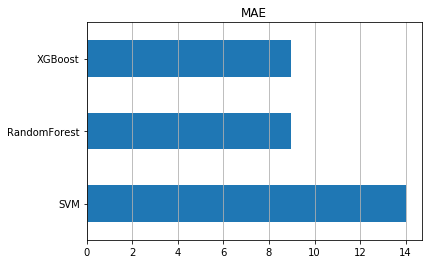

,mae
SVM,13.995320
RandomForest,8.954330
XGBoost,8.950575


In [54]:
# Comparação dos resultados
results = {'SVM': [result_svm], 
           'RandomForest': [result_forest], 
           'XGBoost': [result_xgboost]}
results = pd.DataFrame(results, index=['mae']).transpose()

results.plot(kind='barh', title='MAE', legend=False)
plt.grid(axis='x')
plt.show()

results

## Otimização do Modelo

In [ ]:
n_estimators_list = [110, 120, 140]
lr_list = [0.11, 0.1, 0.08, 0.05]
max_depth_list = [4, 5, 6]

all_scores = {}
for n_trees in n_estimators_list:
    for lr in lr_list:
        for depth in max_depth_list:
            model = XGBRegressor(n_estimators=n_trees, learning_rate=lr, max_depth=depth,
                                 objective='reg:squarederror')
            scores = cross_val_score(model, x_scaled, y, cv=10, scoring='neg_mean_absolute_error')
            all_scores['n_tree={}, lr={}, depth={}'.format(n_trees, lr, depth)] = scores
            
            print('n_estimators={:3d}, lr={:.2f}, max_depth={}: {:.4f} +-{:.4f}'\
                  .format(n_trees, lr, depth, scores.mean(), scores.std()))

## Modelo Final

In [55]:
x = df9.drop(columns=['ENERGY_STAR_Score']).values
y = df9['ENERGY_STAR_Score'].values

# Normalização
scaler_x = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler_x.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, train_size=0.9, random_state=42)

# Treino do Modelo Regressor
xgb_model = XGBRegressor(learning_rate=0.11, n_estimators=110, max_depth=5, objective='reg:squarederror')
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.11, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=110,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

## Realizando Previsões

In [56]:
previsoes_xgb = xgb_model.predict(x_test)

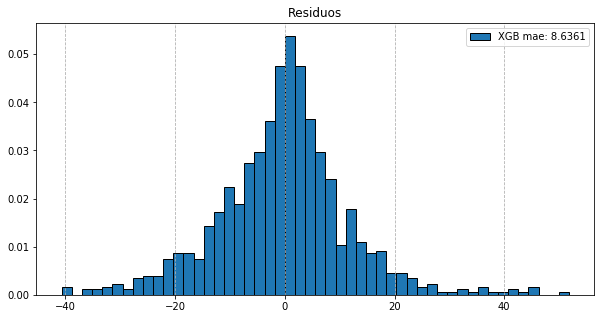

In [60]:
# Distribuição dos Resíduos
residuos_xgb = y_test - previsoes_xgb
avg_residuos_xgb = np.array([abs(res) for res in residuos_xgb]).mean()
std_residuos_xgb = np.array([abs(res) for res in residuos_xgb]).std()

plt.figure(figsize=(10, 5))
plt.hist(residuos_xgb, label='XGB mae: {:.4f}'.format(avg_residuos_xgb),
         bins=50, density=True, edgecolor='black')
plt.title('Residuos')
plt.grid(axis='x', linestyle='--')
plt.legend()
plt.show()